<a href="https://colab.research.google.com/github/ZadneprovskiyNikolay/ml_labs/blob/master/%D0%9A%D0%A02_%D0%97%D0%B0%D0%B4%D0%BD%D0%B5%D0%BF%D1%80%D0%BE%D0%B2%D1%81%D0%BA%D0%B8%D0%B9_%D0%9D_%D0%92_%D0%9C33091.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Рубежная контрольная работа

Эту работу выполнять не обязательно. Баллы, набранные за работу, просуммируются с баллами, которые были набраны за контрольную работу 1, и будут выставлены как оценка за промежуточную аттестацию "автоматом".

Сделайте копию ноутбука.

Присвойте переменной `v` значение - свой табельный номер ИСУ, это нужно для определения вашего варианта. Запустите код в следующей ячейке.

In [1]:
from datetime import datetime
current_datetime = datetime.now()
print(current_datetime)
v = 336276

2023-12-15 13:45:58.048521


# Общее задание

Нужно решить задачу бинарной классификации, предварительно построив признаковое описание объектов на основе нескольких таблиц.

Целевая переменная - пол клиента.

В качестве модели нужно использовать нейронную сеть, которую нужно строить с помощью `keras` или `torch` на выбор студента.

# Данные

Для всех последующих заданий будем использовать обезличенные транзакционные банковские данные. Для этого считайте в переменные **transactions, tr_mcc_codes и gender_train** из одноимённых таблиц из папки data. Для таблицы transactions используйте только первые n=1000000 строк.

Эти данные уже использовались в работе 2. Описание данных тут: https://drive.google.com/file/d/13sn8orjkoGfO1SVZYByXNmZQYFRfmOdp/view?usp=sharing

Скачать данные отсюда: https://drive.google.com/drive/folders/1YAMe7MiTxA-RSSd8Ex2p-L0Dspe6Gs4L?usp=sharing

In [2]:
import pandas as pd

transactions = pd.read_csv('./Data/transactions.csv', delimiter=',', nrows=1_000_000)
tr_mcc_codes = pd.read_csv('./Data/tr_mcc_codes.csv', delimiter=';')
gender_train = pd.read_csv('./Data/gender_train.csv', delimiter=',')

## Задание 1 (6 баллов)

В задании требуется на основе нескольких таблиц с данными сделать признаковое описание объектов.

Объектами являются клиенты. Клиенты идентифицируются с помощью `customer_id`, которые есть в таблицах **transactions** и **gender_train**. В качестве призаков нужно использовать даннее по категориям транзаций: ```mcc_code``` — mcc-код транзакции есть в таблицах **transactions** и **tr_mcc_codes**.


Для выбора варианта запустите код в следующей ячейке.



In [3]:
print ('Список категорий')
feature_list = ['Одежда (также нужно искать "одежды")', 'Аптеки', 'Ценные бумаги', 'Магазины косметики и Салоны красоты', 'Образовательные услуги (а также школы, университеты)',
                'Алименты', 'Прокат автомобилей', 'Автозапчасти, Автошины и Станции техобслуживания (а также СТО)', 'Видеоигры (искать надо по "видеоигр")',
                'Отели', 'Программирование', 'Спиртное и алкоголь', 'Предсказатели будущего', 'Азартные игры']
if (int(str(v)[4]) % 2) == 0:
  print (feature_list[::2])
else:
  print (feature_list[::-2])


if (int(str(v)[5]) % 2) == 0:
  print ('В качестве значений признаков используйте количество транзакций с тратами и количество транзакций с поступлениями')
else:
  print ('В качестве значений признаков используйте сумму по транзакциям с тратами и сумму по транзакциям с поступлениями')

Список категорий
['Азартные игры', 'Спиртное и алкоголь', 'Отели', 'Автозапчасти, Автошины и Станции техобслуживания (а также СТО)', 'Алименты', 'Магазины косметики и Салоны красоты', 'Аптеки']
В качестве значений признаков используйте количество транзакций с тратами и количество транзакций с поступлениями


Каждая категория может быть связана с одним или несколькими mcc-кодами. Например, вот несколько mcc-кодов по категории "Одежда":
* 5621; Готовая женская одежда
* 5641; Детская одежда
* 5651; Одежда для всей семьи

Таким образом получится 14 признаков, то есть семь категорий, каждая из которых даст два значения: траты и поступления. Например, категория "Одежда" даёт признаки "Одежда траты" и "Одежда поступления".

In [4]:
# ['Азартные игры', 'Спиртное и алкоголь', 'Отели', 'Автозапчасти, Автошины и Станции техобслуживания (а также СТО)', 'Алименты', 'Магазины косметики и Салоны красоты', 'Аптеки']
search_category_name_groups = [
    ['азартные игры', 'транзакции по азартным играм'],
    ['спиртное и алкоголь', 'алкоголь', 'магазины с продажей спиртных напитков на вынос'], # 'Магазины с продажей спиртных напитков на вынос' - не совсем ясно подходит ли это т.к. в таком магазине можно покупать не только спиртное, нужно уточнить
    ['отели'], 
    ['автозапчасти', 'автошины', 'станции техобслуживания', r'\bсто\b'],
    ['алименты'],
    ['магазины косметики', 'салоны красоты', 'салоты красоты'], # 'салоты красоты' - опечатка во входных данных
    ['аптеки']]

category_mcc_code_groups = []
for search_category_name_group in search_category_name_groups:
    category_mcc_codes = tr_mcc_codes[tr_mcc_codes['mcc_description'].str.lower().str.contains('|'.join(search_category_name_group))]
    category_mcc_code_groups.append(list(category_mcc_codes['mcc_code']))

#     print(f'{search_category_name_group}:')
#     print(category_mcc_codes, end='\n\n')
    
# category_mcc_code_groups

In [5]:
# ['Азартные игры', 'Спиртное и алкоголь', 'Отели', 'Автозапчасти, Автошины и Станции техобслуживания (а также СТО)', 'Алименты', 'Магазины косметики и Салоны красоты', 'Аптеки']
category_names = ['азартные_игры', 'алкоголь', 'отели', 'авто', 'алименты', 'косметика_и_салоны_красоты', 'аптеки']

X = pd.DataFrame(index=transactions['customer_id'].unique())

feature_names = []
for category_name, category_mcc_codes in zip(category_names, category_mcc_code_groups):
    feature_name_top_up = f'{category_name}_поступления'
    feature_name_withdraw = f'{category_name}_траты'
    feature_names.extend([feature_name_top_up, feature_name_withdraw])

    selected_transactions = transactions.loc[transactions['mcc_code'].isin(category_mcc_codes)]

    top_ups = selected_transactions.loc[selected_transactions['amount'] > 0, ['customer_id', 'mcc_code']] \
        .groupby('customer_id').count().rename(columns={'mcc_code': feature_name_top_up})
    withdrawals = selected_transactions.loc[selected_transactions['amount'] < 0, ['customer_id', 'mcc_code']] \
        .groupby('customer_id').count().rename(columns={'mcc_code': feature_name_withdraw})
    
    X[feature_name_withdraw] = withdrawals
    X[feature_name_top_up] = top_ups

X = X.fillna(0)
X

,азартные_игры_траты,азартные_игры_поступления,алкоголь_траты,алкоголь_поступления,отели_траты,отели_поступления,авто_траты,авто_поступления,алименты_траты,алименты_поступления,косметика_и_салоны_красоты_траты,косметика_и_салоны_красоты_поступления,аптеки_траты,аптеки_поступления
39026145,0.0,0.0,0.0,0.0,0.0,0.0,77.0,0.0,0.0,0.0,0.0,0.0,67.0,0.0
52220754,0.0,0.0,24.0,0.0,2.0,0.0,46.0,0.0,0.0,0.0,0.0,0.0,33.0,0.0
78029866,0.0,0.0,0.0,0.0,0.0,0.0,51.0,0.0,0.0,0.0,1.0,0.0,44.0,0.0
79780256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1585299,0.0,0.0,12.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,7.0,0.0,32.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8942066,0.0,0.0,25.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,5.0,0.0,60.0,0.0
37425501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63145287,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9673243,0.0,0.0,5.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,2.0,0.0,8.0,0.0


Сделайте нормализацию значений признаков так, чтобы все означения менялись от 0 до 1.

In [6]:
# PUT YOUR CODE HERE
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()

X = pd.DataFrame(min_max_scaler.fit_transform(X), index=X.index, columns=X.columns)
X

,азартные_игры_траты,азартные_игры_поступления,алкоголь_траты,алкоголь_поступления,отели_траты,отели_поступления,авто_траты,авто_поступления,алименты_траты,алименты_поступления,косметика_и_салоны_красоты_траты,косметика_и_салоны_красоты_поступления,аптеки_траты,аптеки_поступления
39026145,0.0,0.0,0.000000,0.0,0.000000,0.0,0.390863,0.0,0.0,0.0,0.000000,0.0,0.401198,0.0
52220754,0.0,0.0,0.045541,0.0,0.015625,0.0,0.233503,0.0,0.0,0.0,0.000000,0.0,0.197605,0.0
78029866,0.0,0.0,0.000000,0.0,0.000000,0.0,0.258883,0.0,0.0,0.0,0.006944,0.0,0.263473,0.0
79780256,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
1585299,0.0,0.0,0.022770,0.0,0.000000,0.0,0.065990,0.0,0.0,0.0,0.048611,0.0,0.191617,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8942066,0.0,0.0,0.047438,0.0,0.000000,0.0,0.040609,0.0,0.0,0.0,0.034722,0.0,0.359281,0.0
37425501,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
63145287,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
9673243,0.0,0.0,0.009488,0.0,0.000000,0.0,0.131980,0.0,0.0,0.0,0.013889,0.0,0.047904,0.0


In [7]:
import numpy as np

customer_genders = gender_train
customer_genders.set_index('customer_id', inplace=True)
customer_ids = set(X.index)
y = customer_genders[customer_genders.index.isin(customer_ids)].sort_index()
y

,gender
customer_id,
115617,1
117556,0
189257,1
293048,0
350821,0
...,...
99859464,1
99864691,1
99900908,0


In [8]:
customer_ids_with_gender = set(y.index)
X = X[X.index.isin(customer_ids_with_gender)].sort_index() # оставляем только те датапоинты где определен целевой признак
X

,азартные_игры_траты,азартные_игры_поступления,алкоголь_траты,алкоголь_поступления,отели_траты,отели_поступления,авто_траты,авто_поступления,алименты_траты,алименты_поступления,косметика_и_салоны_красоты_траты,косметика_и_салоны_красоты_поступления,аптеки_траты,аптеки_поступления
115617,0.000000,0.0,0.005693,0.0,0.000000,0.0,0.025381,0.0,0.0,0.0,0.034722,0.0,0.000000,0.0
117556,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.071856,0.0
189257,0.000000,0.0,0.001898,0.0,0.007812,0.0,0.025381,0.0,0.0,0.0,0.013889,0.0,0.005988,0.0
293048,0.000000,0.0,0.003795,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.041667,0.0,0.437126,0.0
350821,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.041916,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99859464,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.010152,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
99864691,0.000000,0.0,0.001898,0.0,0.000000,0.0,0.015228,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
99900908,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.059880,0.0
99967537,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0


## Вопросы к заданию 1

1. Для каждой категории выведите соответствующие ей mcc-коды с описаниями.
2. Выведите количество пустых ячеек по каждому признаку. По какому признаку отсутствует больше всего данных?
3. По какой категории самая большая разница между мужчинами и женщинами?

In [9]:
# 1
for category_name, category_mcc_codes in zip(category_names, category_mcc_code_groups):
    print(category_name)
    print(tr_mcc_codes[tr_mcc_codes['mcc_code'].isin(category_mcc_codes)].set_index('mcc_code'), end='\n\n')

азартные_игры
                       mcc_description
mcc_code                              
7995      Транзакции по азартным играм

алкоголь
                                            mcc_description
mcc_code                                                   
5813      Бары, коктейль-бары, дискотеки, ночные клубы и...
5921      Магазины с продажей спиртных напитков на вынос...

отели
                                           mcc_description
mcc_code                                                  
3501                        Жилье — отели, мотели, курорты
7011      Отели, мотели, базы отдыха, сервисы бронирования

авто
                    mcc_description
mcc_code                           
5532                       Автошины
5533      Автозапчасти и аксессуары
5541        Станции техобслуживания
7538          СТО общего назначения

алименты
                                            mcc_description
mcc_code                                                   
9211      Судовые выплат

In [10]:
# 2
empty_feature_values = {}
for feature_name in feature_names:
    empty_feature_values[feature_name] = (X[feature_name] == 0).sum()

print(empty_feature_values, end='\n\n')
print(sorted(list(empty_feature_values.items()), key=lambda x: x[1], reverse=True)[0])

{'азартные_игры_поступления': 1048, 'азартные_игры_траты': 1016, 'алкоголь_поступления': 1048, 'алкоголь_траты': 648, 'отели_поступления': 1046, 'отели_траты': 918, 'авто_поступления': 1004, 'авто_траты': 463, 'алименты_поступления': 1051, 'алименты_траты': 1051, 'косметика_и_салоны_красоты_поступления': 1050, 'косметика_и_салоны_красоты_траты': 535, 'аптеки_поступления': 1050, 'аптеки_траты': 261}

('алименты_поступления', 1051)


In [11]:
# 3
empty_feature_values_male_female_abs_dif = {}
X_with_genders = X.join(customer_genders)
for feature_name in feature_names:
    empty_values = (
        (X_with_genders.loc[X_with_genders['gender'] == 0, feature_name] == 0).sum(),
        (X_with_genders.loc[X_with_genders['gender'] == 1, feature_name] == 0).sum()
    )
    empty_feature_values_male_female_abs_dif[feature_name] = abs(empty_values[0] - empty_values[1])

print(empty_feature_values_male_female_abs_dif)
print(sorted(list(empty_feature_values_male_female_abs_dif.items()), key=lambda x: x[1], reverse=True)[0])

{'азартные_игры_поступления': 74, 'азартные_игры_траты': 86, 'алкоголь_поступления': 74, 'алкоголь_траты': 116, 'отели_поступления': 74, 'отели_траты': 94, 'авто_поступления': 100, 'авто_траты': 185, 'алименты_поступления': 73, 'алименты_траты': 73, 'косметика_и_салоны_красоты_поступления': 72, 'косметика_и_салоны_красоты_траты': 51, 'аптеки_поступления': 72, 'аптеки_траты': 21}
('авто_траты', 185)


# Задание 2 (3 балла)

Постройте модель - многослойную нейронную сеть минимум с двумя скрытыми слоями и с dropout. Количество нейронов в каждом слое выберите самостоятельно.
Функции активации, метод оптимизации, скорость обучения, параметр для dropout - выберите самостоятельно.

Модель нужно построить с помощью keras или torch.

Настройте параметры модели.

In [12]:
import torch.nn as nn

n = X.shape[-1]

class Model(nn.Module):
    def __init__(self, n_layers, n_neurons):
        super().__init__()

        self.n_layers = n_layers
        self.n_neurons = n_neurons

        self.layers = [nn.Linear(n, n_neurons)]
        self.layers += [nn.Linear(n_neurons, n_neurons) for _ in range(n_layers)]
        for i, layer in enumerate(self.layers, start=1):
            self.__setattr__(f'layer{i}', layer)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.085)
        self.output = nn.Linear(n_neurons, 1)
        self.end_activation = nn.Sigmoid()
 
    def forward(self, x):
        x = self.activation(self.layers[0](x))
        x = self.dropout(x)

        for layer in self.layers[1:]:
            x = self.activation(layer(x))

        x = self.end_activation(self.output(x))
        
        return x

In [13]:
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedKFold, train_test_split

def train_model(model, X_train, y_train, X_test, y_test):
    global epochs, batch_size, learning_rate, momentum

    best_accuracy = 0
    
    loss_fn = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    batch_starts = torch.arange(0, len(X_train), batch_size)

    for _ in range(epochs):
        model.train() # enter train mode
        for batch_start in batch_starts:
            X_batch = X_train[batch_start:batch_start+batch_size]
            y_true_batch = y_train[batch_start:batch_start+batch_size]
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_true_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        model.eval() # enter evaluation mode
        y_pred = model(X_test)
        accuracy = float((y_pred.round() == y_test).float().mean()) # use round() to determine the class
        if accuracy > best_accuracy:
            best_accuracy = accuracy

    return best_accuracy

In [14]:
import torch
 
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.float32)
print(X, end='\n\n')
print(y)

tensor([[0.0000, 0.0000, 0.0057,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0719, 0.0000],
        [0.0000, 0.0000, 0.0019,  ..., 0.0000, 0.0060, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0599, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0024, 0.0000, 0.0076,  ..., 0.0000, 0.0060, 0.0000]])

tensor([[1.],
        [0.],
        [1.],
        ...,
        [0.],
        [1.],
        [1.]])


In [15]:
n_layers = 3
n_neurons = 36
epochs = 300
batch_size = 16
learning_rate = 0.02
momentum = 0.8

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
accuracies = []

kfold = StratifiedKFold(n_splits=5, shuffle=True)
for train_idxs, test_idxs in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Model(n_layers, n_neurons)
    accuracy = train_model(model, X_train[train_idxs], y_train[train_idxs], X_train[test_idxs], y_train[test_idxs])
    accuracies.append(accuracy)
    print(f'Accuracy: {accuracy}')

mean_accuracy = np.mean(accuracies)
print(f'mean accuracy: {mean_accuracy}')

Accuracy: 0.7142857313156128
Accuracy: 0.7823129296302795
Accuracy: 0.7074829936027527
Accuracy: 0.7551020383834839
Accuracy: 0.6938775777816772
mean accuracy: 0.7306122541427612


In [16]:
from torchsummary import summary
summary(model, input_size=X.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 1051, 36]             540
              ReLU-2             [-1, 1051, 36]               0
           Dropout-3             [-1, 1051, 36]               0
            Linear-4             [-1, 1051, 36]           1,332
              ReLU-5             [-1, 1051, 36]               0
            Linear-6             [-1, 1051, 36]           1,332
              ReLU-7             [-1, 1051, 36]               0
            Linear-8             [-1, 1051, 36]           1,332
              ReLU-9             [-1, 1051, 36]               0
           Linear-10              [-1, 1051, 1]              37
          Sigmoid-11              [-1, 1051, 1]               0
Total params: 4,573
Trainable params: 4,573
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/back

## Вопросы к заданию 2

1. Перечислите все гиперпараметры и их значения вот в таком формате (значения приведены просто для примера, у вас могут быть другие):

* количество эпох: 5
* скорость обучения: 0.0001
* функция активация на скрытых слоях: ReLU
* и т.д.

2. Сколько у вашей модели параметров?

# Задание 3 (2 балла)

Оцените качество модели не менее, чем на трех разных метриках.

1.
* разбиение данных при перекрестной проверке: 5 частей
* количество эпох: 300
* разбиение данных при стохастическом спуске: по 16 штук на шаг
* скорость обучения: 0.02
* моментум: 0.8
* кол-во скрытых слоев: 3
* кол-во нейронов в каждом скрытом слое: 36
* функция активация на скрытых слоях: ReLU
* функция активации на последнем слое: Sigmoid
* dropout вероятность: 0.085

2.
кол-во параметров: 4,573

## Вопросы к заданию 3

1. Выведите значения метрик.
2. Как улучшить модель?
3. Для чего может понадобиться предсказание пола клиента по его транзакциям?

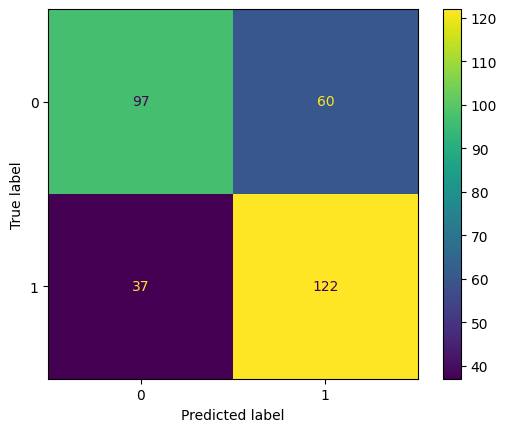

In [17]:
# 1

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = torch.flatten((model(X_test)).round()).detach()
cm = confusion_matrix(y_test, y_pred)

# 1: true positive, true negative, false positive, false negative
ConfusionMatrixDisplay(cm).plot()

2. Убрать признаки с очень малым кол-вом данных, менять гиперпараметры, выявлять и удалять незначимые признаки.
3. Маркетинг.

После завершения контрольной работы дайте ссылку на colab в отдельном followup **в своей теме на Piazza**. Дайте разрешение на его просмотр.

**Не создавайте новую тему, не присылайте решение файлом - только ссылкой.**

Не забудьте запустить код в последней ячейке для контроля времени выполнения.

In [18]:
current_datetime = datetime.now()
print(current_datetime)

2023-12-15 13:47:07.550023
